In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# get dataframe from .txt files
def txt_to_df(fname, repo, category):
    with open(fname, 'r') as f:
        x = f.readlines()
    df = pd.DataFrame([sub.split("\t") for sub in x])
    df.columns = ['Commit','Author','DateTime','Message']
    df['Category'] = category
    df['Repository'] = repository
    return df

path = '/Users/matthewkudija/Documents/GitHub/GitHub-Commits/txt'
files = os.listdir(path)
dfs = []
for file in files:
    if file[-4:]=='.txt':
        splits = file.split('_')
        category = splits[1]
        repository = splits[2].split('.txt')[0]        
        df = txt_to_df('txt/'+file, repository, category)
        dfs.append(df)

df = pd.concat(dfs)
df.tail()

,Commit,Author,DateTime,Message,Category,Repository
923,5d46c91,Matthew Kudija,Wed Oct 19 09:40:04 2016,update formatting\n,Work,Valuations
924,37a75d3,Matthew Kudija,Tue Oct 18 12:43:44 2016,add forward curve and create new subdirectory\n,Work,Valuations
925,6078757,mkudija,Fri Oct 14 15:21:40 2016,adding AW139 analysis for Brett\n,Work,Valuations
926,d61cd79,mkudija,Fri Oct 14 15:21:29 2016,initial commit\n,Work,Valuations
927,a5744f5,"Kudija, Matthew D (Matthew)",Fri Oct 14 14:39:07 2016,Initial commit,Work,Valuations


In [3]:
df.Author.unique()

array(['Matthew Kudija', 'Tapper Tool Co. LLC', 'Hitte, Cory',
       'Kudija, Matthew D', 'Kudija, Matthew D (Matthew)',
       'Laroche, Joseph H (Joe)', 'Laroche, Joseph (Joe)', 'mkudija'], dtype=object)

In [4]:
# clean dates
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = df['DateTime'].dt.date
df['Time'] = df['DateTime'].dt.time#.round('min')#.time

# clean author names
df['Author'] = np.where(df['Author'].isin(['Kudija, Matthew D (Matthew)','Kudija, Matthew D','mkudija']),'Matthew Kudija',df['Author'])
df = df[df['Author']=='Matthew Kudija']

# business day selector
from pandas.tseries.offsets import BDay
isBusinessDay = BDay().onOffset
df['BusinessDay'] = df['Date'].map(isBusinessDay)
df.tail()

,Commit,Author,DateTime,Message,Category,Repository,Date,Time,BusinessDay
923,5d46c91,Matthew Kudija,2016-10-19 09:40:04,update formatting\n,Work,Valuations,2016-10-19,09:40:04,True
924,37a75d3,Matthew Kudija,2016-10-18 12:43:44,add forward curve and create new subdirectory\n,Work,Valuations,2016-10-18,12:43:44,True
925,6078757,Matthew Kudija,2016-10-14 15:21:40,adding AW139 analysis for Brett\n,Work,Valuations,2016-10-14,15:21:40,True
926,d61cd79,Matthew Kudija,2016-10-14 15:21:29,initial commit\n,Work,Valuations,2016-10-14,15:21:29,True
927,a5744f5,Matthew Kudija,2016-10-14 14:39:07,Initial commit,Work,Valuations,2016-10-14,14:39:07,True


In [5]:
# def plot_commits(savePath, title, df):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.grid(ls=':', color='#63666A')
#     plt.style.use('seaborn-paper')

#     # repos = df['Repository'].unique()
#     # for repo in repos:
#     #     dfPlot = df[df['Repository']==repo]
#     #     plt.plot(dfPlot['Date'],dfPlot['Time'],'o', markersize=2, alpha=.5, label=repo)

#     dfPlot = df[df['Category']=='Personal']
#     plt.plot(dfPlot['Date'],dfPlot['Time'],'o', markersize=2, alpha=.5, color='#4169E1', label='Personal')
#     dfPlot = df[df['Category']=='Work']
#     plt.plot(dfPlot['Date'],dfPlot['Time'],'o', markersize=2, alpha=.5, color='#DAA520', label='Work')

#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels)

#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title(title)

#     # format x-axis ticks as dates
#     import matplotlib.dates as mdates
#     years = mdates.YearLocator()   # every year
#     months = mdates.MonthLocator()  # every month
#     yearsFmt = mdates.DateFormatter('\n%Y')
#     moFmt = mdates.DateFormatter('%m') # (%b for Jan, Feb Mar; %m for 01 02 03)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.set_minor_formatter(moFmt)

#     ax.invert_yaxis()
#     plt.savefig(savePath, bbox='tight', dpi=300)

# dfPlot = df.copy()
# plot_commits('Commit_History.png', 'GitHub Commit History', dfPlot)
# dfPlot = dfPlot[dfPlot['BusinessDay']==False]
# plot_commits('Commit_History_weekends.png', 'Weekend Commit History', dfPlot)
# dfPlot = dfPlot[dfPlot['BusinessDay']==True]
# plot_commits('Commit_History_weekdays.png', 'Weekday Commit History', dfPlot)

/Users/matthewkudija/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/matthewkudija/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


<Figure size 432x288 with 0 Axes>

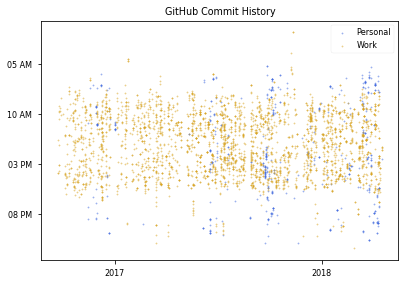

<Figure size 460.8x316.8 with 0 Axes>

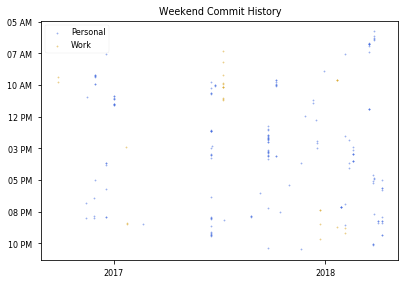

<Figure size 460.8x316.8 with 0 Axes>

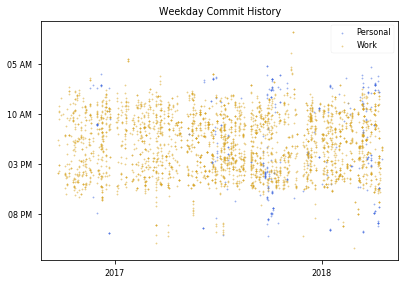

In [6]:
def plot_commits_scatter(savePath, title, df):
    # https://jellis18.github.io/post/2018-01-17-mail-analysis/
    fig = plt.figure()
    plt.style.use('seaborn-paper')
    
    df['timeofday'] = df['DateTime'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)
    df['year'] = df['DateTime'].apply(lambda x: x.year + x.dayofyear/365.25)

    dfPlot = df[df['Category']=='Personal']
    ax = dfPlot.plot.scatter('year', 'timeofday', s=2, alpha=0.5, color='#4169E1', label='Personal')
    dfPlot = df[df['Category']=='Work']
    dfPlot.plot.scatter('year', 'timeofday', s=2, alpha=0.5, color='#DAA520', label='Work', ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

    plt.xlabel('')
    plt.ylabel('')
    plt.title(title)

    # format x-axis ticks as dates
#     import matplotlib.dates as mdates
#     years = mdates.YearLocator()   # every year
#     months = mdates.MonthLocator()  # every month
#     yearsFmt = mdates.DateFormatter('\n%Y')
#     moFmt = mdates.DateFormatter('%m') # (%b for Jan, Feb Mar; %m for 01 02 03)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.set_minor_formatter(moFmt)

    import datetime
    import numpy as np
    
    import matplotlib.ticker as ticker
    majors = [2016, 2017, 2018]
    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_yticks()]);
    ax.invert_yaxis()
    plt.savefig(savePath, bbox='tight', dpi=300)

# dfPlot = df.copy()
plot_commits_scatter('Commit_History_scatter.png', 'GitHub Commit History', df)
dfPlot = df[df['BusinessDay']==False]
# dfPlot = dfPlot[dfPlot['BusinessDay']==False]
plot_commits_scatter('Commit_History_weekends_scatter.png', 'Weekend Commit History', dfPlot)
# dfPlot = dfPlot[dfPlot['BusinessDay']==True]
dfPlot = df[df['BusinessDay']==True]
plot_commits_scatter('Commit_History_weekdays_scatter.png', 'Weekday Commit History', dfPlot)

In [7]:
dfPlot

,Commit,Author,DateTime,Message,Category,Repository,Date,Time,BusinessDay,timeofday,year
0,3923cd2,Matthew Kudija,2018-04-11 17:24:27,notes\n,Personal,blog,2018-04-11,17:24:27,True,17.407500,2018.276523
1,840531c,Matthew Kudija,2018-04-11 17:23:53,Merge branch 'master' of https://github.com/mk...,Personal,blog,2018-04-11,17:23:53,True,17.398056,2018.276523
2,03d3770,Matthew Kudija,2018-04-11 17:22:25,license\n,Personal,blog,2018-04-11,17:22:25,True,17.373611,2018.276523
3,95c10e8,Matthew Kudija,2018-04-10 20:53:47,readme\n,Personal,blog,2018-04-10,20:53:47,True,20.896389,2018.273785
4,6c44758,Matthew Kudija,2018-04-03 19:52:53,add table-filter\n,Personal,blog,2018-04-03,19:52:53,True,19.881389,2018.254620
5,b0bf9a5,Matthew Kudija,2018-04-03 19:52:04,add gh-pages notes\n,Personal,blog,2018-04-03,19:52:04,True,19.867778,2018.254620
6,9480f29,Matthew Kudija,2018-04-03 11:04:35,code with line numbers\n,Personal,blog,2018-04-03,11:04:35,True,11.076389,2018.254620
7,da52631,Matthew Kudija,2018-04-03 11:04:21,start table filter\n,Personal,blog,2018-04-03,11:04:21,True,11.072500,2018.254620
8,4f53e0e,Matthew Kudija,2018-04-02 19:01:52,update code block highlighting to monokai\n,Personal,blog,2018-04-02,19:01:52,True,19.031111,2018.251882
9,b9825d7,Matthew Kudija,2018-03-29 14:36:45,incremental save\n,Personal,blog,2018-03-29,14:36:45,True,14.612500,2018.240931


Get data:

From here: https://gist.github.com/pwenzel/2884698

git log --date=local --pretty=format:"%h%x09%an%x09%ad%x09%s" > ../commits.local.tsv.txt


copy to excel!


In [8]:
%load_ext watermark
%watermark -d -iv

numpy       1.13.3
pandas      0.22.0
matplotlib  2.2.2
2018-04-16
